In [6]:
# notebooks/02_modeling.ipynb

import pandas as pd
import numpy as np
import os
import sys
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib # For saving the model


import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# --- Setup sys.path to import from utils ---
# Get the current working directory of the notebook
current_dir = os.getcwd()
# Assuming the notebook is in 'notebooks/' and project root is one level up
project_root = os.path.dirname(current_dir)
# Add the project root to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the necessary functions from utils.preprocess
# Note: For loading the cleaned data, we'll manually find the latest file.
# preprocess_dataframe is for cleaning raw data, which we did in 01_exploration.
# We will use it later for new raw data if needed.
from utils.preprocess import load_and_concat_raw_data # We will use this to load ALL cleaned files
# --- End sys.path setup ---

In [8]:
df = pd.read_csv('../data/cleaned/bama_cleaned_data_20250709_223000.csv')
df.head()

,brand,model,year,trim_version,price,location,mileage,fuel_type,gearbox,body_condition,body_color,interior_color,ad_url,scrape_date,car_age
0,دنا,پلاس EF7,1402,اتوماتیکتوربوساده,1.050000e+09,تهران/سازمانبرنامه,13000,بنزینی,اتوماتیک,بدون رنگ,مشکی,داخل مشکی,https://bama.ir/car/detail-iofdlmqs-dena-plus-...,2025-07-09 16:38:23.575421,2
1,پژو,2008,1398,اتوماتیک,2.280000e+09,تهران/یوسف‌آباد,16000,بنزینی,اتوماتیک,بدون رنگ,سفید,داخل مشکی,https://bama.ir/car/detail-0iknbils-peugeot-20...,2025-07-09 16:38:18.957451,6
2,پژو,206,1395,تیپ2,4.700000e+08,رشت/توشیبا,219000,بنزینی,دنده ای,بدون رنگ,سفید,داخل مشکی,https://bama.ir/car/detail-xolky4mp-peugeot-20...,2025-07-09 16:38:12.630144,9
3,مکث,موتور، کلوت,1402,اتوماتیکتیپ2,1.010000e+09,تهران/سهروردی,200,بنزینی,اتوماتیک,یک لکه رنگ,مشکی,داخل مشکی,https://bama.ir/car/detail-uxhbo69z-maxmotor-k...,2025-07-09 16:38:06.472255,2
4,پژو,206,1385,تیپ3,2.650000e+08,تهران/پاسداران,264000,بنزینی,دنده ای,دور رنگ,خاکستری,داخل مشکی,https://bama.ir/car/detail-dhrjngce-peugeot-20...,2025-07-09 16:38:01.045577,19


In [9]:
df.isnull().sum()

brand             0
model             0
year              0
trim_version      0
price             0
location          0
mileage           0
fuel_type         0
gearbox           0
body_condition    0
body_color        0
interior_color    0
ad_url            0
scrape_date       0
car_age           0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   brand           709 non-null    object 
 1   model           709 non-null    object 
 2   year            709 non-null    int64  
 3   trim_version    709 non-null    object 
 4   price           709 non-null    float64
 5   location        709 non-null    object 
 6   mileage         709 non-null    int64  
 7   fuel_type       709 non-null    object 
 8   gearbox         709 non-null    object 
 9   body_condition  709 non-null    object 
 10  body_color      709 non-null    object 
 11  interior_color  709 non-null    object 
 12  ad_url          709 non-null    object 
 13  scrape_date     709 non-null    object 
 14  car_age         709 non-null    int64  
dtypes: float64(1), int64(3), object(11)
memory usage: 83.2+ KB


In [12]:
# --- 2. Define Features (X) and Target (y) ---

# Target variable (y)
y = df['price']

# Features (X)
# Drop columns that are not used as features for modeling:
# - 'price': This is our target variable
# - 'ad_url': Unique identifier for the ad, not useful for prediction
# - 'scrape_date': Timestamp of scraping, not directly a feature, but 'car_age' is derived from 'year'
# - 'year': We derived 'car_age' from it, and using both can cause multicollinearity. 'car_age' is usually more direct.
X = df.drop(columns=['price', 'ad_url', 'scrape_date', 'year']) 

In [14]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (709, 11)
y shape: (709,)


In [15]:
X.head()

,brand,model,trim_version,location,mileage,fuel_type,gearbox,body_condition,body_color,interior_color,car_age
0,دنا,پلاس EF7,اتوماتیکتوربوساده,تهران/سازمانبرنامه,13000,بنزینی,اتوماتیک,بدون رنگ,مشکی,داخل مشکی,2
1,پژو,2008,اتوماتیک,تهران/یوسف‌آباد,16000,بنزینی,اتوماتیک,بدون رنگ,سفید,داخل مشکی,6
2,پژو,206,تیپ2,رشت/توشیبا,219000,بنزینی,دنده ای,بدون رنگ,سفید,داخل مشکی,9
3,مکث,موتور، کلوت,اتوماتیکتیپ2,تهران/سهروردی,200,بنزینی,اتوماتیک,یک لکه رنگ,مشکی,داخل مشکی,2
4,پژو,206,تیپ3,تهران/پاسداران,264000,بنزینی,دنده ای,دور رنگ,خاکستری,داخل مشکی,19


In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   brand           709 non-null    object
 1   model           709 non-null    object
 2   trim_version    709 non-null    object
 3   location        709 non-null    object
 4   mileage         709 non-null    int64 
 5   fuel_type       709 non-null    object
 6   gearbox         709 non-null    object
 7   body_condition  709 non-null    object
 8   body_color      709 non-null    object
 9   interior_color  709 non-null    object
 10  car_age         709 non-null    int64 
dtypes: int64(2), object(9)
memory usage: 61.1+ KB


In [ ]:
# --- 3. One-Hot Encoding for Categorical Features ---

# Identify categorical columns (those with 'object' dtype)
categorical_cols = X.select_dtypes(include='object').columns

if len(categorical_cols) == 0:
    print("No categorical columns found for One-Hot Encoding.")
else:
    # Apply One-Hot Encoding using pd.get_dummies()
    # drop_first=True helps to avoid multicollinearity issues in some models
    # and reduces the number of generated columns slightly for binary categories.
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True) 

print(f"X shape after One-Hot Encoding: {X.shape}")

X shape after One-Hot Encoding: (709, 491)


In [18]:
X.head()

,mileage,car_age,brand_ام,brand_اکستریم,brand_اینرودز,brand_برلیانس,brand_بسترن,brand_بی,brand_تارا,brand_تیبا,...,interior_color_داخل نوک مدادی,interior_color_داخل کرم,interior_color_داخلآبی,interior_color_داخلآلبالویی,interior_color_داخلقرمز,interior_color_داخلمارون,interior_color_داخلموکا,interior_color_داخلنقرهای,interior_color_داخلکربنبلک,interior_color_داخلگیلاسی
0,13000,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,16000,6,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,219000,9,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,200,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,264000,19,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Columns: 491 entries, mileage to interior_color_داخلگیلاسی
dtypes: bool(489), int64(2)
memory usage: 349.8 KB


In [20]:
# --- 4. Train-Test Split ---

# X: Features (after One-Hot Encoding)
# y: Target variable (price)

# test_size=0.2 means 20% of the data will be used for testing, 80% for training.
# random_state=42 ensures reproducibility (you get the same split every time you run the code).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("Data split complete. Ready for model training.")

X_train shape: (567, 491)
X_test shape: (142, 491)
y_train shape: (567,)
y_test shape: (142,)
Data split complete. Ready for model training.


In [21]:
# --- 5. Train the Model ---

# Initialize the model
# n_estimators=100: Creates 100 decision trees in the forest. More trees generally mean better performance but longer training time.
# random_state=42: Ensures reproducibility. If you run the code multiple times, you'll get the same results.
# n_jobs=-1: Uses all available CPU cores for training, speeding up the process.
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) 

# Train the model with the training data
model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


Mean Absolute Error (MAE): 219,734,992
Root Mean Squared Error (RMSE): 344,855,896
R-squared (R2 Score): 0.8701


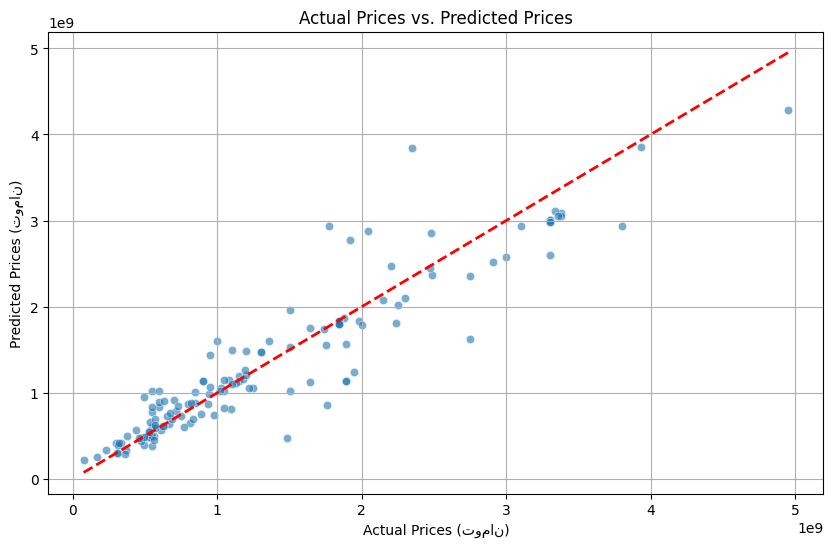

Model evaluation complete.


In [22]:
# --- 6. Evaluate the Model ---

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE is sqrt of MSE
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:,.0f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.0f}")
print(f"R-squared (R2 Score): {r2:.4f}")

# --- Optional: Visualize Predictions vs. Actual ---
# It's always good to visually inspect the predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6) # Scatter plot of actual vs. predicted
plt.title('Actual Prices vs. Predicted Prices')
plt.xlabel('Actual Prices (تومان)')
plt.ylabel('Predicted Prices (تومان)')
# Add a diagonal line for perfect predictions
# This line should go from the minimum of actual/predicted to the maximum
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2) # Ideal line (red dashed)
plt.grid(True)
plt.show()

print("Model evaluation complete.")